In [27]:
from datascience import *
%matplotlib inline
path_data = '../assets/data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

# 13.1 Percentiles (백분위수)

### 수치 예시

80번째로 큰 수를 구한다 가정할 때, 우리는 80%분위의 수를 찾는다

In [2]:
sizes = make_array(12, 17, 6, 9, 7)

다음과 같이 크기가 5인 집단에서 80%에 해당하는 수는 4 / 5로 4번째 값인 12이다.

In [3]:
np.sort(sizes)

array([ 6,  7,  9, 12, 17], dtype=int64)

만약 70%에 해당하는 값은 3.5번째로 4번째 즉 12일것이다.

### `percentile()` function

In [4]:
percentile(70, sizes)

12

일반적으로 `percentile()` 함수는 백분위수를 나타낸다.

### 예제

전체 359명 학생의 데이터가 주어졌다.

In [5]:
scores_and_sections = Table.read_table(path_data + 'scores_by_section.csv')
scores_and_sections

Section,Midterm
1,22
2,12
2,23
2,14
1,20
3,25
4,19
1,24
5,8
6,14


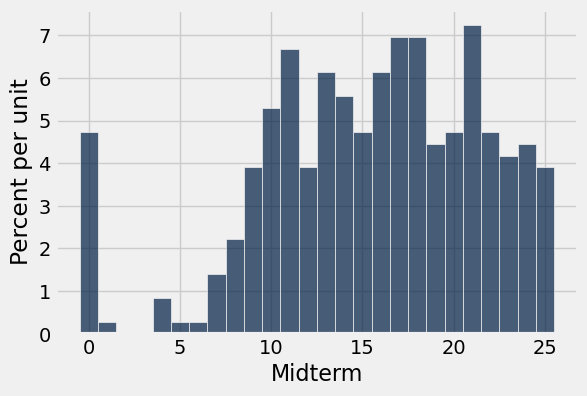

In [6]:
scores_and_sections.select('Midterm').hist(bins=np.arange(-0.5, 25.6, 1))
plt.show()

In [7]:
scores = scores_and_sections.column(1)

In [8]:
percentile(85, scores)

22

`percentile()` 함수에 따르면 85%는 22이다. 이것이 정의와 일치하는지 알아보자.

In [11]:
sorted_scores = np.sort(scores_and_sections.column(1))

In [12]:
0.85 * 359

305.15

In [13]:
# The 306th element of the sorted array

sorted_scores.item(305)

22

전체에서 85% 등수는 305등인 것을 알 수 있고, 305등의 점수는 22점이다.

### Quartiles (4분위수)

In [14]:
percentile(25, scores)

11

In [15]:
percentile(50, scores)

16

In [16]:
percentile(75, scores)

20

# 13.2 Bootstrap

In [19]:
sf2019 = Table.read_table(path_data + 'san_francisco_2019.csv')
sf2019.show(3)

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Information Systems,IS Trainer-Journey,91332,0,40059,131391
Public Protection,Adult Probation,Information Systems,IS Engineer-Assistant,123241,0,49279,172520
Public Protection,Adult Probation,Information Systems,IS Business Analyst-Senior,115715,0,46752,162468


In [20]:
sf2019.where('Job', 'Mayor')

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
General Administration & Finance,Mayor,Administrative & Mgmt (Unrep),Mayor,342974,0,98012,440987


In [21]:
sf2019.sort('Total Compensation')

Organization Group,Department,Job Family,Job,Salary,Overtime,Benefits,Total Compensation
Public Protection,Adult Probation,Probation & Parole,Deputy Probation Officer,0,0,0,0
Public Protection,Fire Department,"Clerical, Secretarial & Steno",Senior Clerk Typist,0,0,0,0
Public Protection,Juvenile Court,Correction & Detention,"Counselor, Juvenile Hall PERS",0,0,0,0
Public Protection,Police,"Clerical, Secretarial & Steno",Clerk Typist,0,0,0,0
Public Protection,Sheriff,Correction & Detention,Deputy Sheriff,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,Sub-Professional Engineering,StdntDsgn Train2/Arch/Eng/Plng,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,"Clerical, Secretarial & Steno",Executive Secretary 1,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,"Payroll, Billing & Accounting",Senior Account Clerk,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,Housekeeping & Laundry,Custodian,0,0,0,0
"Public Works, Transportation & Commerce",Airport Commission,Housekeeping & Laundry,Custodian,0,0,0,0


In [22]:
sf2019 = sf2019.where('Salary', are.above(15000))

In [23]:
sf2019.num_rows

37103

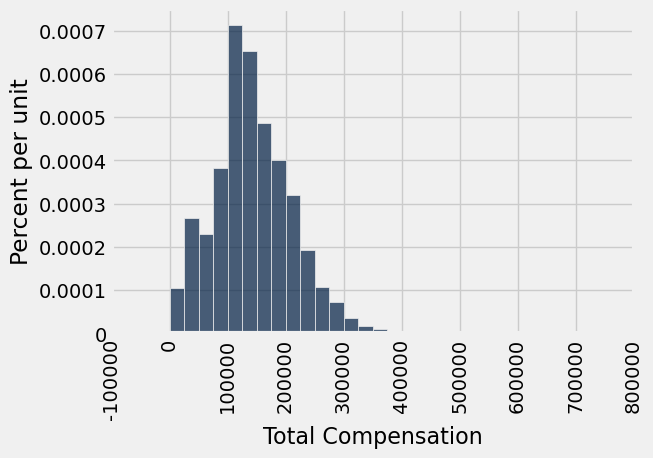

In [29]:
sf_bins = np.arange(0, 726000, 25000)
sf2019.select('Total Compensation').hist(bins=sf_bins)
plots.show()

In [30]:
pop_median = percentile(50, sf2019.column('Total Compensation'))
pop_median

135747.0

### 랜덤 샘플링 그리고 추정

무작위 500명을 뽑아 표본을 추출하고, 중앙값을 매개변수의 추정치로 사용한다.

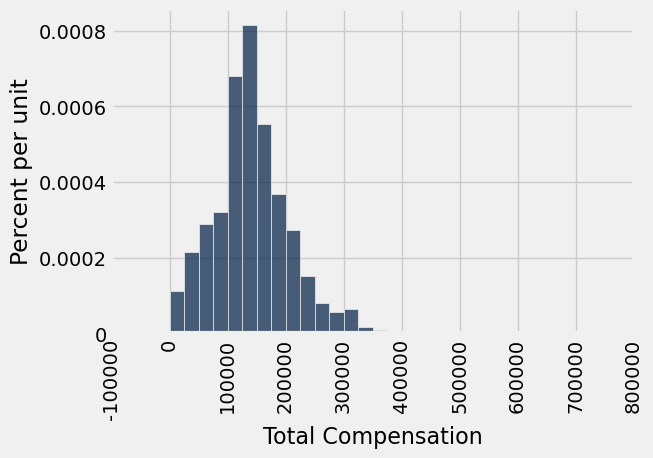

In [31]:
our_sample = sf2019.sample(500, with_replacement=False)
our_sample.select('Total Compensation').hist(bins=sf_bins)
plots.show()

In [32]:
est_median = percentile(50, our_sample.column('Total Compensation'))
est_median

137058.0

현재 모집단의 크기가 매우 크다. 그 중 500개를 무작위로 뽑아 분포를 그렸을 때, 해당 분포는 모집단을 따를 것이다. 

우리는 새로 500개를 뽑는 것이 아닌, 뽑아놓은 500개를 리샘플링하여 표본을 다시 뽑아낼 것이다.

### 부트스트랩 작동 이유

평균의 법칙에 따라 샘플의 분포는 모집단의 분포를 따른다.

### 리샘플링된 중앙값

In [33]:
resample_1 = our_sample.sample()

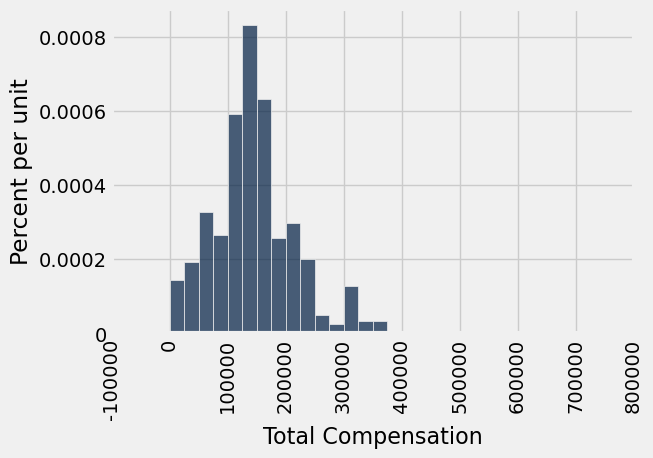

In [34]:
resample_1.select('Total Compensation').hist(bins=sf_bins)
plots.show()

In [35]:
resampled_median_1 = percentile(50, resample_1.column('Total Compensation'))
resampled_median_1

140402.0

In [36]:
resample_2 = our_sample.sample()
resampled_median_2 = percentile(50, resample_2.column('Total Compensation'))
resampled_median_2

140675.0

리샘플링을 통해 중앙값에 대한 다양한 추정치를 얻을 수 있다.

In [37]:
def one_bootstrap_median():
    resampled_table = our_sample.sample()
    bootstrapped_median = percentile(50, resampled_table.column('Total Compensation'))
    return bootstrapped_median

In [38]:
one_bootstrap_median()

136915.0

In [39]:
num_repetitions = 5000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append (bstrap_medians, one_bootstrap_median())

즉, 500개를 샘플링한 분포에서 리샘플링하여 중앙값을 구하는 과정을 5000번 반복한다.

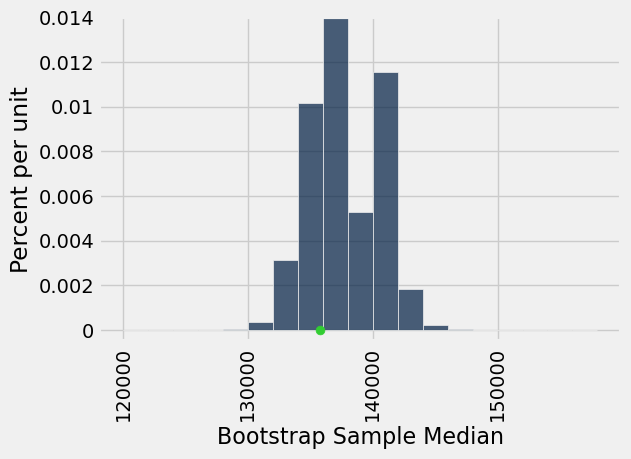

In [40]:
resampled_medians = Table().with_column('Bootstrap Sample Median', bstrap_medians)
median_bins=np.arange(120000, 160000, 2000)
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
parameter_green = '#32CD32'
plots.ylim(-0.000005, 0.00014)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.show()

초록점이 모집단의 중앙값이다. 우리는 이 값을 추정하기 위한 것이다.

### 추정치가 매개변수를 포착하는가?

In [41]:
left = percentile(2.5, bstrap_medians)
left

132680.0

In [42]:
right = percentile(97.5, bstrap_medians)
right

142400.0

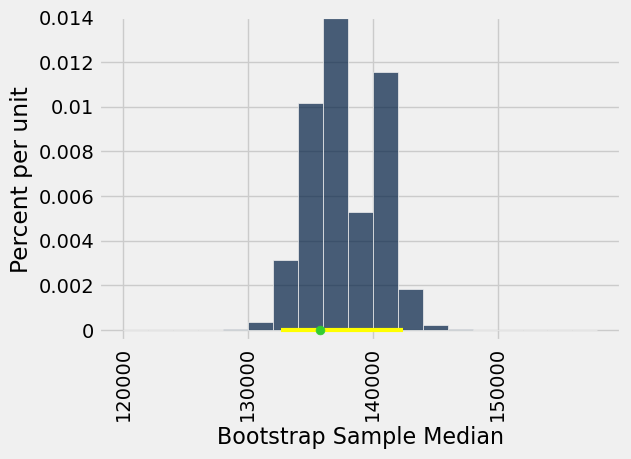

In [43]:
resampled_medians.hist(bins = median_bins)

# Plotting parameters; you can ignore this code
plots.ylim(-0.000005, 0.00014)
plots.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1)
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.show()

신뢰구간 95%에 대해 구간 내에 초록 점이 있는것을 알 수 있다.

In [44]:
def bootstrap_median(original_sample, num_repetitions):
    medians = make_array()
    for i in np.arange(num_repetitions):
        new_bstrap_sample = original_sample.sample()
        new_bstrap_median = percentile(50, new_bstrap_sample.column('Total Compensation'))
        medians = np.append(medians, new_bstrap_median)
    return medians

In [45]:
# THE BIG SIMULATION: This one takes several minutes.

# Generate 100 intervals and put the endpoints in the table intervals

left_ends = make_array()
right_ends = make_array()

for i in np.arange(100):
    original_sample = sf2019.sample(500, with_replacement=False)
    medians = bootstrap_median(original_sample, 5000)
    left_ends = np.append(left_ends, percentile(2.5, medians))
    right_ends = np.append(right_ends, percentile(97.5, medians))

intervals = Table().with_columns(
    'Left', left_ends,
    'Right', right_ends
)    

이번에는 5000번 리샘플링하여 중앙값을 구한 다음, 그 중앙값이 신뢰구간 95%에 해당하는 값을 100개 뽑아낸다.

In [46]:
intervals

Left,Right
132517,147828
126676,137003
131429,145493
129159,141389
127019,140310
132447,149338
131289,142702
126088,140330
132718,143154
123131,137573


In [47]:
intervals.where(
    'Left', are.below(pop_median)).where(
    'Right', are.above(pop_median)).num_rows

99

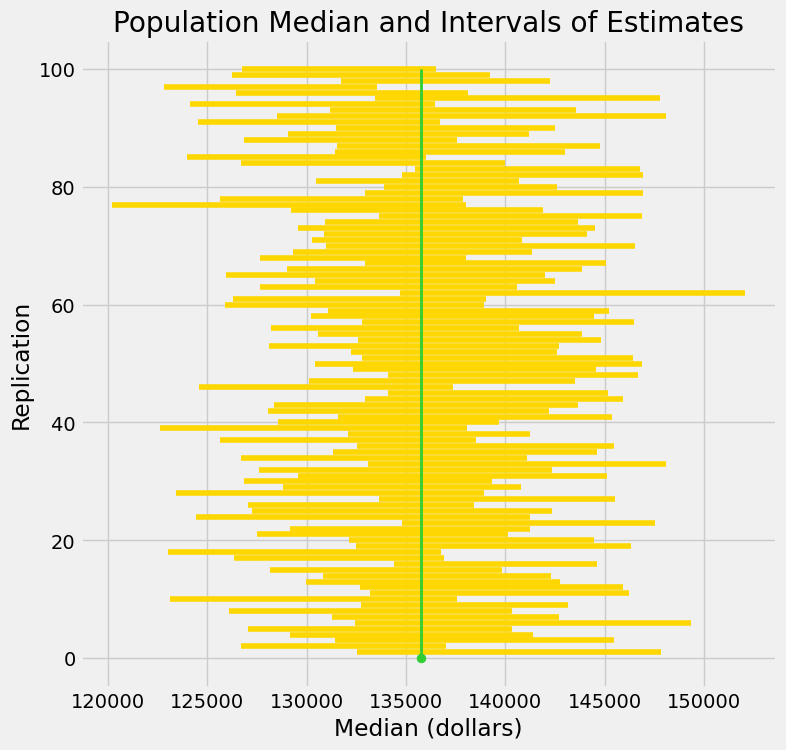

In [48]:
replication_number = np.ndarray.astype(np.arange(1, 101), str)
intervals2 = Table(replication_number).with_rows(make_array(left_ends, right_ends))

plots.figure(figsize=(8,8))
for i in np.arange(100):
    ends = intervals2.column(i)
    plots.plot(ends, make_array(i+1, i+1), color='gold')
plots.scatter(pop_median, 0, color=parameter_green, s=40, zorder=2)
plots.plot(make_array(pop_median, pop_median), make_array(0, 100), color=parameter_green, lw=2)
plots.xlabel('Median (dollars)')
plots.ylabel('Replication')
plots.title('Population Median and Intervals of Estimates')
plots.show()

# 13.3 Confidence Intervals (신뢰 구간)

In [49]:
births = Table.read_table(path_data + 'baby.csv')

In [50]:
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


임신 일수와 신생아의 출산 체중 사이의 관계를 조사하여 신생아의 출산 체중을 추정하려 한다.

In [51]:
ratios = births.select('Birth Weight', 'Gestational Days').with_columns(
    'Ratio BW:GD', births.column('Birth Weight')/births.column('Gestational Days')
)
ratios

Birth Weight,Gestational Days,Ratio BW:GD
120,284,0.422535
113,282,0.400709
128,279,0.458781
108,282,0.382979
136,286,0.475524
138,244,0.565574
132,245,0.538776
120,289,0.415225
143,299,0.478261
140,351,0.39886


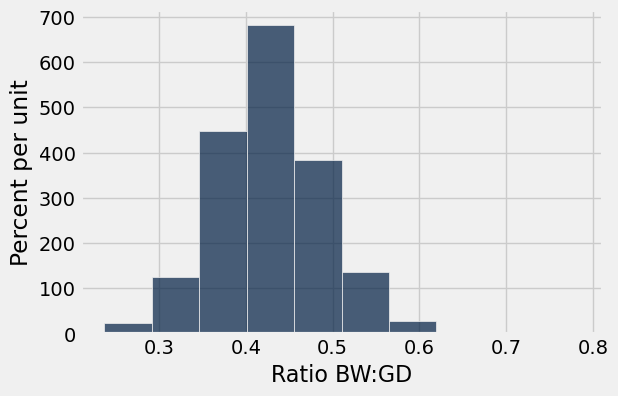

In [52]:
ratios.select('Ratio BW:GD').hist()
plots.show()

대부분의 값은 0.4 ~ 0.45 정도에 분포한다.

In [53]:
ratios.sort('Ratio BW:GD', descending=True).take(0)

Birth Weight,Gestational Days,Ratio BW:GD
116,148,0.783784


하지만 일부 특이한 값이 존재한다. 이는 0.78 온스를 넘으며 평균값에 거의 두 배에 달한다.

In [54]:
percentile(50, ratios.column(2))

0.42907801418439717

중앙값은 0.429 온스 정도 이다.

하지만 모집단의 중앙값은? 우리는 모르기 때문에 추정할 필요가 있다.

샘플을 5000개 부트스트랩하여 중앙값 추정치 5000개를 뽑아낸다. 95% 신뢰 구간은 모든 추정치의 중앙 95%가 될 것이다.

### 부트스트랩 신뢰 구간 구성

In [55]:
def one_bootstrap_median():
    resample = ratios.sample()
    return percentile(50, resample.column('Ratio BW:GD')) # 50% 구간 = median

In [56]:
one_bootstrap_median()

0.42857142857142855

In [57]:
# Generate medians from 5000 bootstrap samples
num_repetitions = 5000
bstrap_medians = make_array()
for i in np.arange(num_repetitions):
    bstrap_medians = np.append(bstrap_medians, one_bootstrap_median())

In [58]:
# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_medians)
right = percentile(97.5, bstrap_medians)

make_array(left, right) # 신뢰도 95% 구간

array([ 0.42545455,  0.43262411])

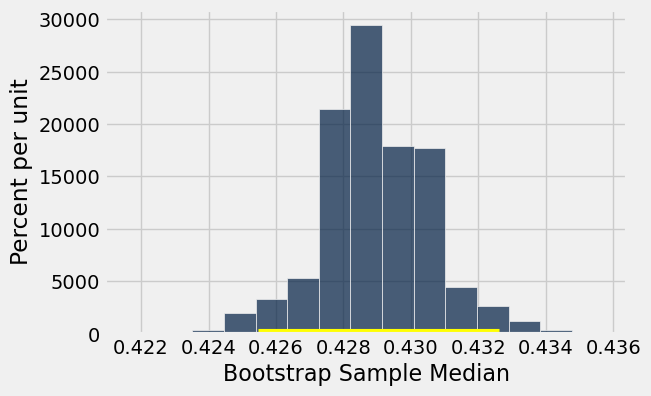

In [59]:
resampled_medians = Table().with_columns(
    'Bootstrap Sample Median', bstrap_medians
)
resampled_medians.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8)
plots.show()

95% 신뢰 구간은 0.425 ~ 0.432 이다. 기존 집단의 중앙값인 0.429는 해당 구간의 중앙값 정도 된다.

해당 그림에는 추정치의 구간만 존재한다. 추정치를 생성하는 과정에서 95%의 좋은 구간이 발생하기 때문에 95% 신뢰 구간이다.

### 인구 평균 추정

중앙값에 대해 수행한 작업은 평균에 대해서도 수행할 수 있다. 모집단에 속한 엄마들의 평균 연령을 추정한다고 가정하자.

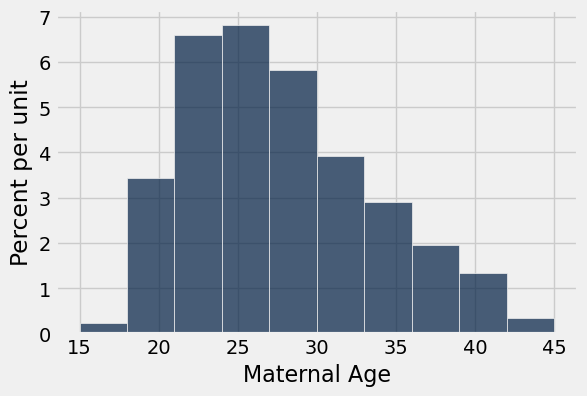

In [60]:
births.select('Maternal Age').hist()
plots.show()

In [61]:
np.average(births.column('Maternal Age'))

27.228279386712096

현재 데이터의 엄마의 평균 나이는 27.2세다. 인구 전체의 엄마의 나이는? 우리는 알 수 없다.

부트스트랩 방법으로 해당 매개변수를 추정해보자.

In [62]:
def one_bootstrap_mean():
    resample = births.sample()
    return np.average(resample.column('Maternal Age'))

In [63]:
# Generate means from 5000 bootstrap samples
num_repetitions = 5000
bstrap_means = make_array()
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())

In [64]:
# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_means)
right = percentile(97.5, bstrap_means)

make_array(left, right)

array([ 26.89352641,  27.55962521])

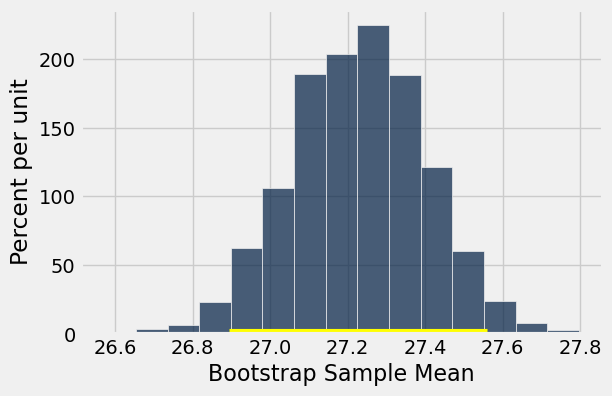

In [65]:
resampled_means = Table().with_columns(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8)
plots.show()

95%의 신뢰 구간은 약 26.9 ~ 27.6이다. 기존 표본의 평균 값인 27.2는 거의 중앙값에 가깝다. 

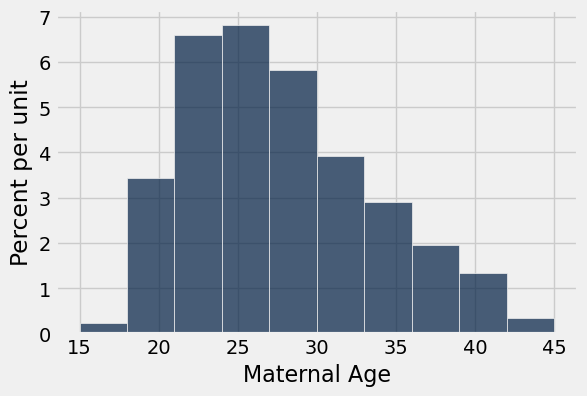

In [66]:
births.select('Maternal Age').hist()
plots.show()

기존의 분포는 다음과 같지만, 부트스트랩한 결과의 분포는 종모양에 유사하다.

이는 확률과 통계의 중심 극한 정리의 결과이다.

### 80% 신뢰 구간

In [67]:
left_80 = percentile(10, bstrap_means)
right_80 = percentile(90, bstrap_means)
make_array(left_80, right_80)

array([ 27.00255537,  27.44889267])

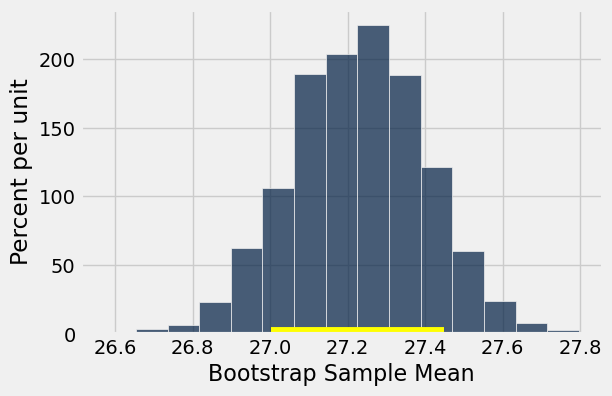

In [68]:
resampled_means.hist(bins=15)
plots.plot([left_80, right_80], [0, 0], color='yellow', lw=10)
plots.show()

80% 신뢰 구간은 95%의 신뢰 구간보다 당연히 짧다. 27.0 ~ 27.4에 불과하다. 이는 좁은 추정치이지만, 이 과정에서 80%의 좋은 구간만 생성된다는 것을 알 수 있다.

### 인구 비율 추정

샘플에서 39%의 산모가 임신 중 흡연을 하였다.

In [69]:
births.where('Maternal Smoker', are.equal_to(True)).num_rows / births.num_rows

0.3909710391822828

In [70]:
smoking = births.column('Maternal Smoker')
np.count_nonzero(smoking) / len(smoking)

0.3909710391822828

인구 중 산모의 몇 퍼센트가 임신 중 흡연을 했는가? 우리는 이를 모른다. 그렇기에 부트스트랩으로 추정할 수 있다.

In [71]:
def one_bootstrap_proportion():
    resample = births.sample()
    smoking = resample.column('Maternal Smoker')
    return np.count_nonzero(smoking) / len(smoking)

In [72]:
# Generate proportions from 5000 bootstrap samples
bstrap_proportions = make_array()
num_repetitions = 5000
for i in np.arange(num_repetitions):
    bstrap_proportions = np.append(bstrap_proportions, one_bootstrap_proportion())

In [73]:
# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_proportions)
right = percentile(97.5, bstrap_proportions)

make_array(left, right)

array([ 0.36286201,  0.41908007])

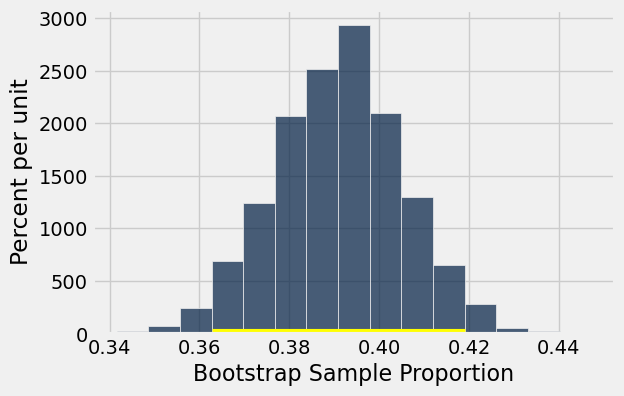

In [74]:
resampled_proportions = Table().with_columns(
    'Bootstrap Sample Proportion', bstrap_proportions
)
resampled_proportions.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8)
plots.show()

신뢰 구간 95%는 0.36 ~ 0.42임을 알 수 있다.

따라서 전체 인구의 36% ~ 42%의 산모가 95%의 신뢰도로 임신 중 흡연을 했다는 사실을 알 수 있다.

# 13.4 Using Confidence Intervals (신뢰 구간 사용)

신뢰 구간은 단일 목적을 가지고 있습니다 - 무작위 표본의 데이터를 기반으로 알려지지 않은 매개변수를 추정하는 것입니다. 

마지막 섹션에서 우리는 이 구간(36%, 42%)이 인구 중 어머니 중 흡연자의 비율에 대한 약 95% 신뢰 구간이라고 말했습니다. 이는 우리의 추정에 따르면 인구 중 어머니 중 흡연자의 비율이 36%에서 42% 사이이며, 우리의 추정 과정이 약 95% 정도 정확하다고 공식적으로 말하는 방식이었습니다.

다른 목적으로 신뢰 구간을 사용하려는 충동을 참는 것이 중요합니다. 예를 들어, 모집단의 어머니 평균 연령에 대한 약 95% 신뢰 구간으로 구간(26.9세, 27.6세)을 계산했다는 점을 기억하세요. 이 구간을 잘못 사용하는 실망스러울 정도로 흔한 사례는 여성의 약 95%가 26.9세에서 27.6세 사이라는 결론을 내리는 것입니다. 신뢰 구간에 대해 많이 알 필요는 없지만, 95%의 어머니가 서로 몇 달 이내에 나이가 있을 것이라고 예상할 수는 없습니다. 실제로 표본 연령의 히스토그램은 상당한 변동을 보여줍니다.

In [76]:
births = Table.read_table(path_data + 'baby.csv')

### 가설 검증을 위한 신뢰 구간 사용하기

인구 평균 연령에 대해 26.9 ~ 27.6세 임이 신뢰도 95%를 가지고 있다. 이를 테스트해보자.

귀무 가설 : 인구의 평균 연령은 30세이다.

p-value에 대해 5% 컷오프를 사용하는 경우 귀무 가설을 기각할 수 있다. 30이 95% 신뢰 구간 내에 있지 않기 때문이다. 

In [78]:
hodgkins = Table.read_table(path_data + 'hodgkins.csv')
hodgkins.show(3)

height,rad,chemo,base,month15
164,679,180,160.57,87.77
168,311,180,98.24,67.62
173,388,239,129.04,133.33


In [80]:
hodgkins = hodgkins.with_columns(
    'drop', hodgkins.column('base') - hodgkins.column('month15')
)
hodgkins

height,rad,chemo,base,month15,drop
164,679,180,160.57,87.77,72.8
168,311,180,98.24,67.62,30.62
173,388,239,129.04,133.33,-4.29
157,370,168,85.41,81.28,4.13
160,468,151,67.94,79.26,-11.32
170,341,96,150.51,80.97,69.54
163,453,134,129.88,69.24,60.64
175,529,264,87.45,56.48,30.97
185,392,240,149.84,106.99,42.85
178,479,216,92.24,73.43,18.81


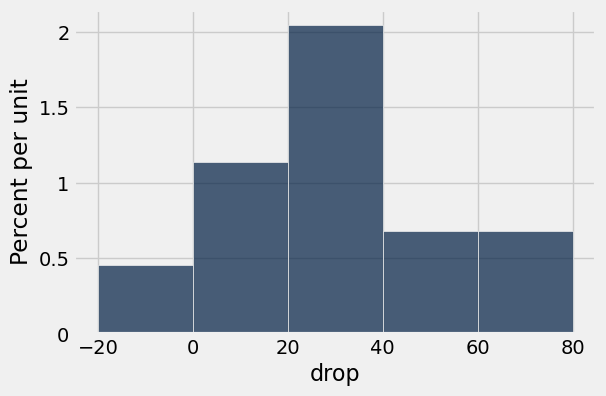

In [81]:
hodgkins.select('drop').hist(bins=np.arange(-20, 81, 20))
plots.show()

In [82]:
np.average(hodgkins.column('drop'))

28.615909090909096

샘플의 평균 하락폭은 28이다. 이것은 우연에 의한 결과인가? 평균 하락폭이 0이 될 수도 있을까?

귀무가설 : 모집단에서 평균 하락율은 0이다.

대립가설 : 모집단에서 평균 하락율은 0이 아니다.

이 가설을 p-value 컷오프 1%로 테스트 한다.

In [83]:
def one_bootstrap_mean():
    resample = hodgkins.sample()
    return np.average(resample.column('drop'))

In [84]:
# Generate 10,000 bootstrap means
num_repetitions = 10000
bstrap_means = make_array()
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())

In [85]:
# Get the endpoints of the 99% confidence interval
left = percentile(0.5, bstrap_means)
right = percentile(99.5, bstrap_means)

make_array(left, right)

array([ 17.37045455,  40.28727273])

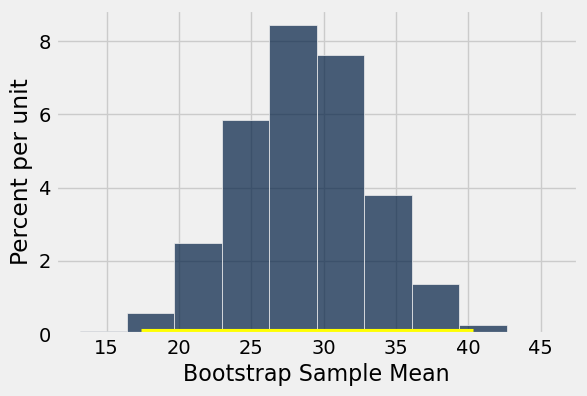

In [86]:
resampled_means = Table().with_columns(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist()
plots.plot([left, right], [0, 0], color='yellow', lw=8)
plots.show()

인구의 평균 감소에 대한 99%의 구간은 17 ~ 40이다. 따라서 0을 포함하지 않으므로 귀무 가설 기각이다. 

우리는 단순히 인구의 평균 감소가 0이 아님을 증명하는 것 보다 더 큰 성과를 거두었다. 우리는 평균 감소가 얼마나 큰지를 추정해내었다.